![Qiskit](https://github.com/Qiskit/qiskit-tutorials/raw/115c78962dda85bac29d679063b7d0d0ab1d1ab4/images/qiskit-heading.gif)

# Qiskit Bootcamp Part III: Aqua

donny@ibm.com

# Gameplan

* Overview and basics
  * What is Aqua?
  * Structural Elements
  * Control flow
  * Interfaces
* Detailed component overview
* Tips and Tricks
* Learning more

But first, install Aqua:

In [1]:
#!pip install qiskit-aqua

In [2]:
import warnings
warnings.filterwarnings(action='once')

# What is Aqua?

Aqua is:
* An easy to use library for running many different quantum algorithms
* A collection of reusable components which can be mixed and matched in different algorithms

Aqua is very practically driven
* We have real chemists and clients who are trying to get things done
* It is exactly what you’d expect to spring out of rapid practical need… it is very function-driven and evolves rapidly
* The guts are not so inviting in some places because it is engineered and optimized to the nines
* If you need to do something, there is a good chance someone already put it in Aqua or should
  * **Please submit feature requests!**

Aqua is built to be highly extensible and have a diversity of available interfaces:
* Declarative: Creating a QuantumAlgorithm object in python with a config dict and calling run()
* Objective: Constructing QuantumAlgorithm and component objects manually
* Aqua GUI (available separately via `pip install qiskit-aqua 
* Command line interface


# Plug and play components, not a circuit library

Keep in mind:

Aqua organizes reusable components into buckets, elements of which can be substituted for one another:
* Algorithms
* Variational forms
* Optimizers
* Other smaller buckets (translators, QFTs, oracles, feature maps)

It is not so much an “I give you parameters, you give me back a circuit” library, because in nearly all cases, running an algorithm is much more than executing a single circuit (e.g. VQE, q-kernel SVM, etc.)

It’s not even so much about “give me x component,” it’s more “execute this algorithm, with this set of components,” allowing you to mix and match or add your own components

There are many tests, which give good examples of execution modes and components, as well as tutorials in the qiskit-tutorials repo

Get an IDE (Pycharm is good!) and step through the code!


# Structural Elements

It is easy to see Aqua as being composed of roughly four high-level elements:
* Algorithms - the control flow and logic in generally well contained inside the algorithm class file. 
* Interfaces - Aqua is meant to be highly accessible, so it has a lot of infrascructure to allow the graphical or JSON interfaces to be almost equally accessible as coding against the library directly (no small feat!)
   * JSON definitions and declarative interfaces are dispersed throughout
   * The UI and CLI are in the top level Aqua directory
* Components - These are objects which are shared by several algorithms, as mentioned above.
* Utilities - Aqua has many useful modules and helper classes that an algorithm and application developer might want. Examples include the [operator class](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/operator.py), [random matrix generator](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/utils/random_matrix_generator.py), [cnx](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/utils/cnx.py), [run_circutis.py](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/utils/run_circuits.py), and much more.

# The Maxcut problem

Today, we're going to focus on a combinatorial optimization problem called **Maxcut**, which is solved by dividing the nodes of a weighted graph into two groups such that the egdes between the two groups carry the most possible weight. There's an [excellent notebook](https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/aqua/optimization/maxcut_and_tsp.ipynb) 📒 by Mezzacapo et al that goes into the problem in more detail, which I highly recommend. For our purposes, reviewing solution paths is a more important use of our time, and we will not be spending much time on the translation between the graph problem and the qubit operator.

Our solution path starts like this - we represent each node on the graph by a qubit, and the 0 or 1 state of the qubit represents which of the two groups each node occupies in a possible solution. Binary strings are possible solutions, describing how to divide the nodes into |0> group and |1> group. We can take the weights of the graph and turn them into a cost matrix on the vector space of these strings, such that this cost matrix represents an Ising hamiltonian whose minimum eignestate is our optimal solution.

Let's begin with a weight matrix w, representing the weights between edges of the graph. To make it easier to follow along with the above mentioned notebook, we'll use the same cost matrix.

In [5]:
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.translators.ising import maxcut
from qiskit.aqua.input import EnergyInput

# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config

In [6]:
w = np.array([[0., 1., 1., 1.,],
 [1., 0., 1., 0.,],
 [1., 1., 0., 1.,],
 [1., 0., 1., 0.,]])

qubitOp, offset = maxcut.get_maxcut_qubitops(w)
algo_input = EnergyInput(qubitOp)

In [7]:
print(qubitOp.paulis)

[[0.5, Pauli(z=[True, True, False, False], x=[False, False, False, False])], [0.5, Pauli(z=[True, False, True, False], x=[False, False, False, False])], [0.5, Pauli(z=[False, True, True, False], x=[False, False, False, False])], [0.5, Pauli(z=[True, False, False, True], x=[False, False, False, False])], [0.5, Pauli(z=[False, False, True, True], x=[False, False, False, False])]]


In [8]:
qubitOp.to_matrix()
print(qubitOp.matrix)
# Note, these are the diagonal elements

[ 2.5 -0.5  0.5 -0.5 -0.5 -1.5 -0.5  0.5  0.5 -0.5 -1.5 -0.5 -0.5  0.5
 -0.5  2.5]


For simplicity, we'll be using the declarative interface to Aqua today, which is accessed via a configuration dictionary.

In [10]:
aqua_dict = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': {'name': 'VQE','operator_mode': 'matrix'},
    'optimizer': {'name': 'SPSA','max_trials': 300},
    'variational_form': {'name': 'RY','depth': 5,'entanglement': 'linear'},
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(aqua_dict, algo_input)

x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

sol = maxcut.get_graph_solution(x)
sol

energy: -1.4999726515373513
time: 5.688199758529663
maxcut objective: -3.9999726515373513
solution: [1. 0. 1. 0.]
solution objective: 4.0


array([1., 0., 1., 0.])

Now, let's try a new optimizer. This is a big part of the power of Aqua. The Aqua team spends time making the components broadly compatable, so experimentation is cheap and easy.

In [11]:
aqua_dict = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': {'name': 'VQE','operator_mode': 'matrix'},
    'optimizer': {'name': 'SLSQP'},
    'variational_form': {'name': 'RY','depth': 5,'entanglement': 'linear'},
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(aqua_dict, algo_input)

x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

sol = maxcut.get_graph_solution(x)
sol

energy: -1.49999997646803
time: 2.791951894760132
maxcut objective: -3.99999997646803
solution: [1. 0. 1. 0.]
solution objective: 4.0


array([1., 0., 1., 0.])

Empirical notes on optimizers:
* COBYLA is a generally good global optimizer, especially in situations when you do not have a good starting point
* SLSQP is very good when you have a good starting point, and the error surface can be approximated in small cavities by quadratic functions
* SPSA is generally resilient to noise, so almost always the first choise for running on the hardware or noisy simulations

Now let's try a new variational form:

In [12]:
aqua_dict = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': {'name': 'VQE','operator_mode': 'matrix'},
    'optimizer': {'name': 'SLSQP'},
    'variational_form': {'name': 'RYRZ','depth': 5,'entanglement': 'linear'},
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(aqua_dict, algo_input)

x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

sol = maxcut.get_graph_solution(x)
sol

energy: -1.4999952980825784
time: 22.096724033355713
maxcut objective: -3.9999952980825784
solution: [1. 0. 1. 0.]
solution objective: 4.0


array([1., 0., 1., 0.])

That seemed to work worse. We can also increase variational form depth:

In [13]:
aqua_dict = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': {'name': 'VQE','operator_mode': 'matrix'},
    'optimizer': {'name': 'SLSQP'},
    'variational_form': {'name': 'RY','depth': 8,'entanglement': 'linear'},
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(aqua_dict, algo_input)

x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

sol = maxcut.get_graph_solution(x)
sol

energy: -1.4999999013985974
time: 5.321591138839722
maxcut objective: -3.9999999013985974
solution: [1. 0. 1. 0.]
solution objective: 4.0


array([1., 0., 1., 0.])

In many cases we can even swap out the **algorithm**:

In [15]:
aqua_dict = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': {'name': 'QAOA.Variational','operator_mode': 'matrix', 'p':2},
    'optimizer': {'name': 'COBYLA'},
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(aqua_dict, algo_input)

x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

sol = maxcut.get_graph_solution(x)
sol

energy: -0.7244926451189756
time: 67.38786005973816
maxcut objective: -3.2244926451189757
solution: [0. 1. 0. 1.]
solution objective: 4.0


array([0., 1., 0., 1.])

# Interfaces: Dictionary vs. Declaration

The form above relies on a dictionary to construct the Aqua components, and is convenient for many use cases. The dictionary allows you to experiment with low-risk changes to the algorithm in a cheap and straightforward way. 

In addition, objects can be constructed explicitly via imports and constructors. This allows you to reuse or modify components more daringly, and most algorithms developers eventully take this route for many parts of their work.

# Quick Demo: Aqua UI

_Note: The following shell command can only be run locally_

In [ ]:
!qiskit_aqua_ui

# Other Neat Stuff

Aqua has many core algorithms, including:
* VQE
* QAOA
* QPE/iterativeQPE
* Hamiltonian Evolution
* Quantum-Kernel SVM
* Variational SVM
* Grover’s

# Example: Quantum ML with Support Vector Machines

Q-Kernel SVM: We use a standard classical SVM with a “quantum kernel.” The kernel is an nxn matrix (n is the number of training samples), where matrix element m, p is generated by running short variational circuits of the form ⟨variational _form(m)|variational_form(p)⟩ for every point m, p in the training set. Note that a single point m is a list of features. This kernel extends the reach of the feature space beyond what we believe is possible classically.

Q-Variational SVM: To train, we input a sample as the initial state of a short variational circuit, with parameters, and read the result (mod 2) to find the circuit’s classification. We optimize the parameters of the variational circuit classically to improve the model’s classification accuracy.
Warning: the variational svm can be very slow to converge.

Task below: attempt to fit a very nonlinear function, f(x,y) = x*y


In [14]:
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import SVMInput
import time
from sklearn import svm

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

Let's start by creating and visalizing our sample data.

In [7]:
train_size = 50
test_size = 20

x_trn = (np.random.random(train_size)*2)-1
y_trn = (np.random.random(train_size)*2)-1
greater = [[x,y] for x,y in zip(x_trn,y_trn) if x*y >=0]
less = [[x,y] for x,y in zip(x_trn,y_trn) if x*y < 0]
training_data = {"greater": greater, "less":less}
print(training_data)

x_tst = (np.random.random(test_size)*2)-1
y_tst = (np.random.random(test_size)*2)-1
greater = [[x,y] for x,y in zip(x_tst,y_tst) if x*y >=0]
less = [[x,y] for x,y in zip(x_tst,y_tst) if x*y < 0]
test_data = {"greater": greater, "less":less}
print(test_data)

{'greater': [[-0.9338678711407751, -0.7307947401161514], [-0.5598688103411122, -0.6515678639282179], [0.5501583529295941, 0.8456940104358661], [0.9132835912018911, 0.4983351979253705], [-0.4467893968427088, -0.31400309515418035], [0.8746047956045457, 0.18985673426624872], [0.46416119444943416, 0.06601278806585054], [-0.5850504056907522, -0.8723349394821716], [-0.06926433317136849, -0.4020370937964146], [0.22112187540741535, 0.38312838749286793], [-0.45821848529414155, -0.01628247565523755], [-0.3717097133074052, -0.29027819270087307], [-0.4317864177790003, -0.008707556116296589], [0.9898707231157553, 0.3183189596930309], [0.5836259696209378, 0.38399233617875295], [-0.7347983193048226, -0.35272926907810676], [0.9328102821016746, 0.3780163224492814], [0.8715497212116923, 0.14568569489718586], [0.24352718443454546, 0.06823079646061303], [0.45482885996367206, 0.9905845867303416], [-0.04712911076546611, -0.292851406468952], [0.9892364760422405, 0.29399661814326805], [0.21944685338922088, 0.

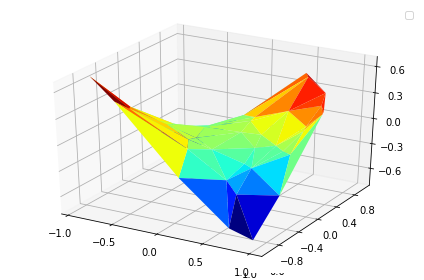

In [9]:
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x_trn, y_trn, x_trn*y_trn, cmap=cm.jet, linewidth=0) #Jet4Ever
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

ax.legend()
plt.show()

Let's define a function to fit the data with the quantum kernel svm, and test it. This will take a while, maybe 20-30 minutes. It scales with O(n^2).

In [17]:
def aqua_qksvm_score(tr_input, te_input, shots=100):
    aqua_params = {
        'problem': {'name': 'svm_classification'},
        'backend': {'name': 'qasm_simulator', 'shots': shots},
        'algorithm': {'name': 'QSVM.Kernel'}
    }
    algo_input = SVMInput(training_dataset=tr_input, test_dataset=te_input)
    t0 = time.process_time()
    result = run_algorithm(aqua_params, algo_input)
    t1 = time.process_time()
    return result, (t1 - t0)/60

In [13]:
result, proc_time = aqua_qksvm_score(training_data, test_data, shots=100)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

85.0%
Process time: 70.91417206666667 mins


Now let's try swapping it out for the Variational SVM. This will probably take closer to 10 minutes.

In [14]:
def aqua_variational_svm_score(tr_input, te_input, shots=10):
    aqua_params = {
        'problem': {'name': 'svm_classification'},
        'backend': {'name': 'qasm_simulator', 'shots': shots},
        'algorithm': {'name': 'QSVM.Variational'},
        'optimizer': {'name': 'SPSA'},
        'variational_form': {'name': 'RYRZ', 'depth': 2}
    }
    algo_input = get_input_instance('SVMInput')
    algo_input.training_dataset = tr_input
    algo_input.test_dataset = te_input
    t0 = time.process_time()
    result = run_algorithm(aqua_params, algo_input)
    t1 = time.process_time()
    return result, (t1 - t0)/60

In [15]:
result, proc_time = aqua_variational_svm_score(training_data, test_data, shots=100)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

75.0%
Process time: 188.68027673333333 mins


And for good measure, let's score these against a popular set of classical SVM kernels:

In [22]:
def classical_svm_score(samples_tr, labels_tr, samples_te, labels_te, kernel='linear'):
    model = svm.SVC(kernel=kernel, gamma='auto')
    model.fit(samples_tr, labels_tr)
    return model.score(samples_te, labels_te)

In [23]:
samples_train = list(zip(x_trn, y_trn))
samples_test = list(zip(x_tst, y_tst))
labels_train = [x*y>=0 for [x,y] in samples_train]
labels_test = [x*y>0 for [x,y] in samples_test]

perf = {'rbf':[], 'linear':[], 'poly':[], 'sigmoid':[]}
for key in perf:
    perf[key] = classical_svm_score(samples_train, 
                                        labels_train, 
                                        samples_test, 
                                        labels_test, 
                                        kernel=key)
print(perf)

{'rbf': 0.8, 'linear': 0.45, 'poly': 0.4, 'sigmoid': 0.4}


# Tips and tricks (Basically the same as Terra...)

* Put many circuits into a single execution!
  * Simulators will (generally) execute these in parallel
  * Quantum Hardware does a lot of calibration for each new job, so if you send 100 jobs it will generally take 100x as long as one job with 100 circuits, even if the circuits are completely different!
* The “qasm_simulator” (cpp) backend fails gracefully over to the “qasm_simulator_py,” which is ~5x slower!
  * (ctrl-f for 'failing gracefully')
* Consider commenting out Qobj validation if you need more speed in an iterative algo, but don’t tell anyone who told you so!
* Use an IDE!! A lot of people at IBM use Pycharm. Being able to step through the code is critical!
* Look at the debug log messages. There is a ton of important info in there. See notebook here
  * Even better, save them to a file.

In [24]:
import logging
logging.getLogger('qiskit').setLevel(logging.DEBUG)

Redirecting logs to a file:

```
# Redirecting debug logs to a file (can't be done in colab):
    loggerc = logging.getLogger('qiskit_chemistry')
    loggerc.setLevel(logging.DEBUG)
    loggera = logging.getLogger('qiskit_aqua')
    loggera.setLevel(logging.DEBUG)
    loggerq = logging.getLogger('qiskit')
    loggerq.setLevel(logging.DEBUG)
    formatter = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    hdlr = logging.FileHandler(outdir + log_file_name, mode='w')
    hdlr.setFormatter(formatter)
    loggerc.addHandler(hdlr)
    loggera.addHandler(hdlr)
    loggerq.addHandler(hdlr)
    print('\nlog file: {}'.format(outdir + log_file_name))
# <build, execute, etc.>
# close up handlers
    loggerc.removeHandler(hdlr)
    loggera.removeHandler(hdlr)
    loggerq.removeHandler(hdlr)
    hdlr.close()
```

# Part IV: Qiskit Chemistry

# Qiskit Chemistry is a Convenient Wrapper Around Aqua and Popular Chemistry Drivers

* Qiskit Chemistry is an even more practitioner-centric tool, specifically for Chemists
* It includes two other component buckets that are not in Aqua: Chemistry drivers, and mappings (Jordan-Wigner, Bravyi-Kitaev, parity, etc.)
* The interfaces look very similar to Aqua - instantiation with a dictionary, or a standalone UI, etc.
* The core service of Qiskit Chemistry is to prepare all of the required calculations for the hamiltonian and other important observables before attempting to do Chemistry simulation or eigendecomposition in Aqua


In [ ]:
!pip install qiskit-chemistry
!pip install pyscf

In [26]:
import numpy as np
import pylab
from qiskit.chemistry import QiskitChemistry

# Most Important Thing to Grasp - the Execution Flow:

* Qiskit Chemistry discovers components and reads config dictionaries
* Most fancy Chemistry package features are allowed, like orbital removal, qubit tapering, core freezing, etc.
* Calls Chemistry Drivers to calculate single and double excitation integrals
* Uses mapping to create a hamiltonian circuit out of operators for each excitation
* Calls VQE in Aqua to find eigenstates of the hamiltonian (e.g. ground state energy)
  * Also passes aux_ops (auxiliary operators) for Aqua to calculate at the end: spin, particle number, dipole moment, etc.
* Aqua creates an “evaluate_energy” function which: 
  * Takes in a scalar parameter list, creates a variational form (UCCSD, RyRz, Swap-Rz, your own, etc.) parameterized by the list
  * Executes the variational circuit + the hamiltonian circuit (or does math in the background to simulate the result quickly without sending the full circuit to the simulator)
  * Returns the resulting energy of the system
* Aqua instantiates an optimizer, and passes the energy function as the cost function to minimize
  * Use COBYLA if running on statevector simulator, SPSA if running on shot-based (qasm) because it performs well in the presence of noise
* The optimizer minimizes the energy, and returns the optimal parameters when complete
* Aqua re-creates the ground state with the optimal params, and calculates and returns the ground state energy and auxiliary operators

Let's start with a simple example, NaH:

In [ ]:
qiskit_chemistry_dict = {
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': 'H .0 .0 .0; Na .0 .0 1.1', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': 'parity',
                 'two_qubit_reduction': True, 'freeze_core': True, 'orbital_reduction': [-3, -2]},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA', 'maxiter': 10000 },
    'variational_form': {'name': 'RYRZ'},
    'initial_state': {'name': 'HartreeFock'},
    'backend': {'name': 'statevector_simulator'}
}

solver = QiskitChemistry()
result = solver.run(qiskit_chemistry_dict)

In [22]:
for line in result['printable']:
    print(line)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -165.447505593877
  - computed part:      -0.865174133601
  - frozen energy part: -164.582331460276
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 5.2917721092
> Total ground state energy (Hartree): -160.155733484677
  Measured:: Num particles: 2.000, S: 0.000, M: -0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  0.0  21.48240175]
  - computed part:      [0.0  0.0  0.7359935]
  - frozen energy part: [0.0  0.0  20.74640824]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  0.0  22.86568611]
> Dipole moment (a.u.): [0.0  0.0  1.38328436]  Total: 1.38328436
               (debye): [0.0  0.0  3.51595782]  Total: 3.51595782


Now, let's plot the full dissociation profile for LiH (this will take a while - maybe over 20 minutes). Notice, on line 43, that we reuse the optimal parameters from a given point as the initial parameters when we begin the following point. This gives us adiabatic-ish effects without having to run at extremely small distance steps.

Based on [this notebook](https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/aqua/chemistry/dissociation_profile_of_molecule.ipynb) by Mezzacapo et al.

In [ ]:
import numpy as np
import pylab
from qiskit.chemistry import QiskitChemistry

# Input dictionary to configure Qiskit Chemistry for the chemistry problem.
qiskit_chemistry_dict = {
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': 'parity',
                 'two_qubit_reduction': True, 'freeze_core': True, 'orbital_reduction': [-3, -2]},
    'algorithm': {'name': ''},
    'optimizer': {'name': 'COBYLA', 'maxiter': 10000 },
    'variational_form': {'name': 'RYRZ'},
    'initial_state': {'name': 'HartreeFock'},
    'backend': {'name': 'statevector_simulator'}
}
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
algorithms = [{'name': 'VQE'},
              {'name': 'ExactEigensolver'}]

pts = np.around(np.arange(.8, 2.2, .1), decimals = 2)
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
eval_counts = np.zeros([len(algorithms), len(pts)], dtype=np.intp)

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    qiskit_chemistry_dict['PYSCF']['atom'] = molecule.format(d/2) 
    for j in range(len(algorithms)):
        qiskit_chemistry_dict['algorithm'] = algorithms[j] 
        solver = QiskitChemistry()
        result = solver.run(qiskit_chemistry_dict)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j]['name'] == 'VQE':
            eval_counts[j][i] = result['algorithm_retvals']['eval_count']
            if j == 1:
                algorithms[j]['initial_point'] = result['algorithm_retvals']['opt_params']
    distances[i] = d
print(' --- complete')

In [23]:
print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step 13 --- complete
Distances:  [0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1]
Energies: [[-7.63040117 -7.72079684 -7.76898319 -7.82352056 -7.83561579 -7.86654234
  -7.87685108 -7.86636898 -7.88071149 -7.87729704 -7.87320771 -7.86558452
  -7.86004946 -7.85243824]
 [-7.63097825 -7.72081241 -7.7822424  -7.82359928 -7.85069838 -7.86756329
  -7.87700149 -7.88101572 -7.88107204 -7.87826817 -7.87344029 -7.86723396
  -7.86015321 -7.85259583]]
Hartree-Fock energies: [-7.61577016 -7.70575334 -7.76736214 -7.80874318 -7.83561583 -7.85195386
 -7.86053866 -7.86335762 -7.86186477 -7.85714496 -7.8500187  -7.84111204
 -7.83090558 -7.81977026]
VQE num evaluations: [[10000  8708 10000 10000  2646 10000 10000 10000 10000 10000 10000 10000
  10000 10000]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


# Tips!

* The examples above are somewhat naive, there are techniques to improve them by several orders of magnitude
* $|\text{Spin orbitals}| \approx |\text{qubits}|$ - if you increase the size of the molecule or basis, your classical execution time increases exponentially
* You don’t need to use VQE to find eigenstates! You can use QPE, QAOA, or whatever else
* Your initial point matters a lot. The way you move along a dissociation curve can dictate the fate of your resutlts.
* UCCSD is nice but it will not be runnable on Quantum hardware for a long time.
* Optimization over non-convex high-dimensional error surfaces is hard. I am sorry about that.